# ABC calibration of $I_\text{CaL}$ in standardised model to unified dataset.

In [5]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [7]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Li1997]
 - Activation time constant [Li1997]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant (fast+slow) [Li1997]
 - Recovery time constant (fast+slow) [Li1997]

In [1]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
modelfile = 'models/standardised_ical.mmt'

Plot steady-state and tau functions of original model (pretty much meaningless for standardised)

In [3]:
from ionchannelABC.visualization import plot_variables

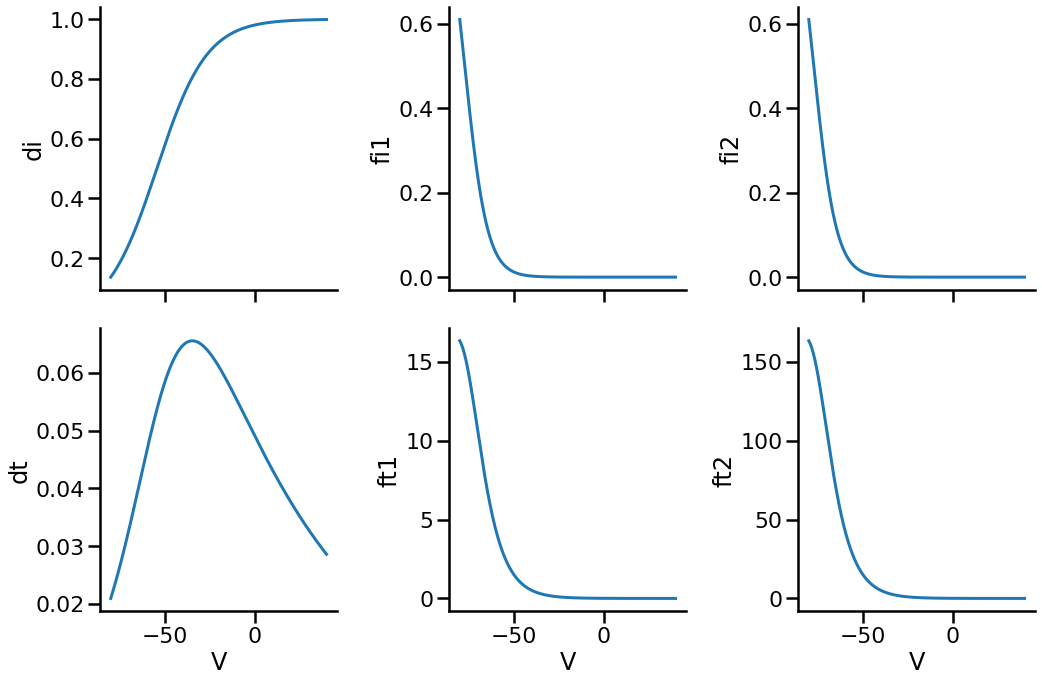

In [8]:
sns.set_context('poster')

V = np.arange(-80, 40, 0.01)

sta_par_map = {'di': 'ical.d_ss',
            'fi1': 'ical.f_ss',
            'fi2': 'ical.f_ss',
            'dt':  'ical.tau_d',
            'ft1': 'ical.tau_f1',
            'ft2': 'ical.tau_f2'}

f, ax = plot_variables(V, sta_par_map, 'models/standardised_ical.mmt', figshape=(3,2))

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [9]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [10]:
assert len(observations)==len(summary_statistics(model({})))

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [11]:
limits = {'log_ical.p_1': (-7, 3),
          'ical.p_2': (1e-7, 0.4),
          'log_ical.p_3': (-7, 3),
          'ical.p_4': (1e-7, 0.4),
          'log_ical.p_5': (-7, 3),
          'ical.p_6': (1e-7, 0.4),
          'log_ical.p_7': (-7, 3),
          'ical.p_8': (1e-7, 0.4),
          'log_ical.A': (0., 3.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [12]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "standardised_ical.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 512 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9678753977594495, '1': 0.9678753977594495, '2': 0.9678753977594495, '3': 0.9678753977594495, '4': 0.9678753977594495, '5': 0.9678753977594495, '6': 0.9678753977594495, '7': 0.8108388442136876, '8': 0.4949276062083544, '9': 0.40434403902433114, '10': 0.3182415505473346, '11': 0.32995173747223605, '12': 0.4054194221068438, '13': 0.9678753977594495, '14': 0.9678753977594495, '15': 0.9678753977594495, '16': 0.948320343641584, '17': 1.106143311725085, '18': 1.106143311725085, '19': 1.106143311725085, '20': 1.106143311725085, '21': 0.3661134182449056, '22': 0.5684392546434062, '23': 0.7593993167501771, '24': 0.9437195392623547, '25': 1.106143311725085, '26': 1.106143311725085, '27': 1.106143311725085, '28': 1.0340756653619416, '29': 0.9437195392623547, '30': 0.7095117703943247, '31': 0.5182027705336358, '32': 0.47053527060396233, '33': 0.4147752932240028, '34': 0.47137080052372676, '35': 0.24685138829306388, '36': 0.5737108704898386, '37': 0.86131728575

In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-18 17:22:03.606784, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Analysis of results

In [16]:
history = History('sqlite:///results/standardised/ical/standardised_ical.db')

In [17]:
df, w = history.get_distribution(m=0)

In [18]:
df.describe()

name,ical.p_2,ical.p_4,ical.p_6,ical.p_8,log_ical.A,log_ical.p_1,log_ical.p_3,log_ical.p_5,log_ical.p_7
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.003388e-02,0.099215,0.047113,0.020810,0.788764,-2.279925,-0.265797,-1.103523,-1.645750
std,1.854605e-02,0.064192,0.008913,0.006414,0.188636,2.374954,0.483495,0.207245,0.084571
min,2.178800e-07,0.005585,0.023634,0.004977,0.485648,-6.974685,-2.288536,-1.418141,-1.901053
25%,6.549153e-03,0.055825,0.040431,0.015896,0.615048,-4.742626,-0.636091,-1.234576,-1.701939
50%,1.373577e-02,0.076499,0.047816,0.019931,0.782965,-1.570045,-0.092676,-1.156520,-1.634931
75%,2.664200e-02,0.123537,0.053845,0.025588,0.877211,-0.144836,0.128086,-1.070517,-1.589531
max,8.244987e-02,0.386201,0.069720,0.040497,1.369025,0.246579,0.411409,-0.492833,-1.231217


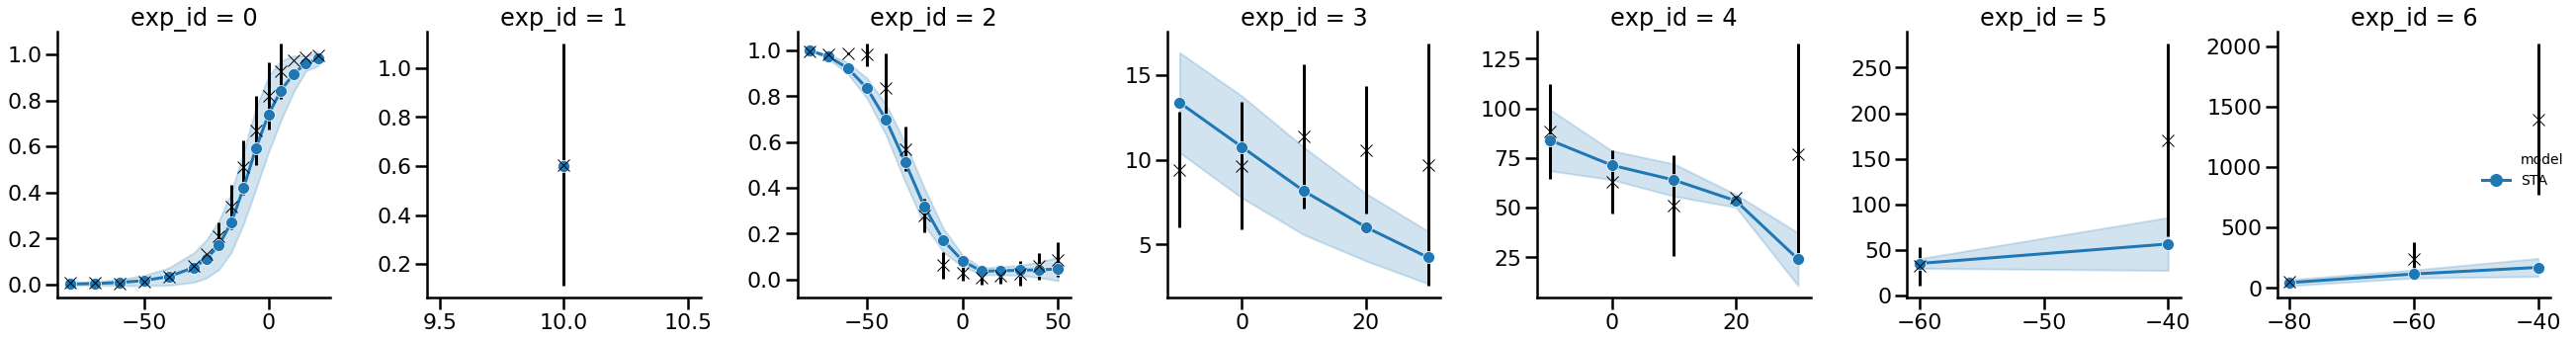

In [19]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14


g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

plt.tight_layout()

In [20]:
import pandas as pd
N = 100
sta_par_samples = df.sample(n=N, weights=w, replace=True)
sta_par_samples = sta_par_samples.set_index([pd.Index(range(N))])
sta_par_samples = sta_par_samples.to_dict(orient='records')

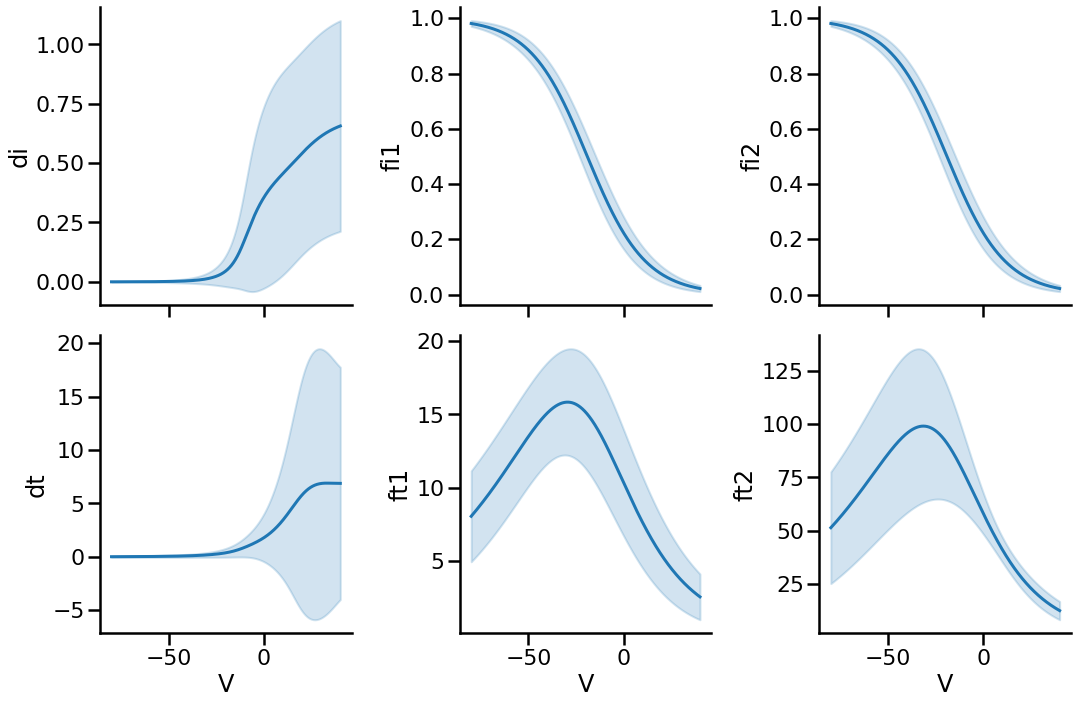

In [21]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, sta_par_map, 
                       'models/standardised_ical.mmt', 
                       [sta_par_samples],
                       figshape=(3,2))

In [22]:
m,_,_ = myokit.load(modelfile)

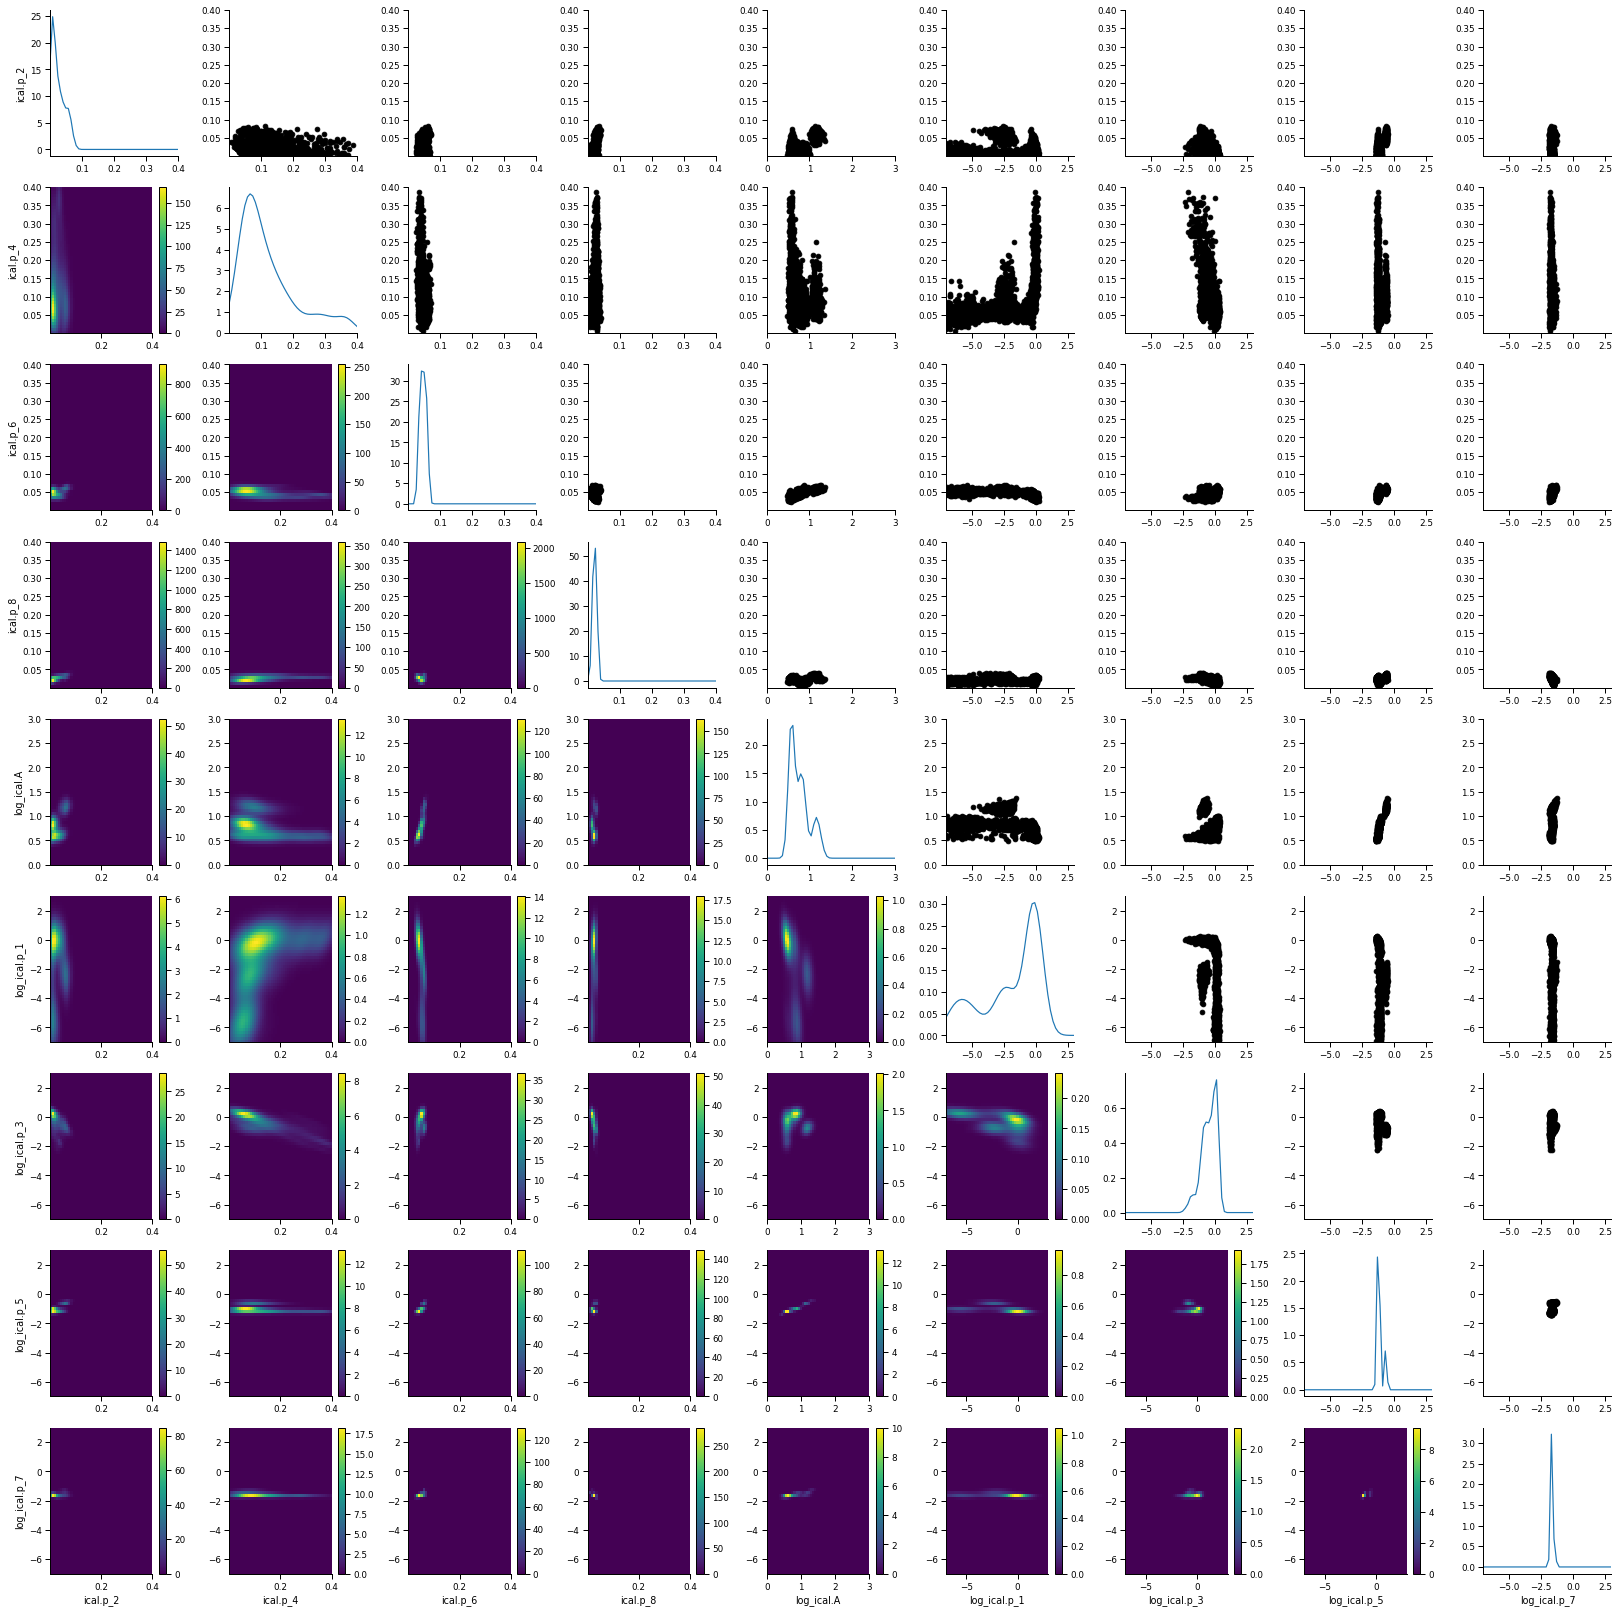

In [23]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits)
plt.tight_layout()